In [2]:
## Imports

import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import scipy as scp
import scipy.special
from numpy.fft import fftshift, ifftshift, ifft2, fftn, ifftn
import sigpy as sp
from sigpy.mri import dcf
import scipy.misc
from pynufft import NUFFT

In [50]:
def generate_ksp_cylinder(a, h, size, kmax=0.5):
    '''Returns k-space of cylinder, generated from cylinder radius'''

    ## Create k-space grid
    k_range = np.linspace(-kmax, kmax, size)
    KX, KY, KZ = np.meshgrid(k_range, k_range, k_range, indexing='ij')

    ## Transverse plane
    K_xy = np.sqrt(KX**2 + KY**2)
    K_xy[K_xy==0] = 1e-10  #in case of zero division

    F_xy = 2*np.pi*(a**2)*scipy.special.jv(1,K_xy*a)/(K_xy*a)
    F_z = np.sinc(KZ*h/(2*np.pi))*h
    ## Move z-component to be first axis
    F_k = np.swapaxes(F_xy*F_z, 0, 2)
    
    return F_k, kmax

def shift_pixels(F_k, kmax, shift_pixels_coord):
    '''Returns k-space of cylinder, with additional phase term to represent spatial shift'''
    size = F_k.shape[0]
    k_range = np.linspace(-kmax, kmax, size)
    KX, KY, KZ = np.meshgrid(k_range, k_range, k_range, indexing='ij')
    ## shift pixels should be x,y shift
    sx, sy = shift_pixels_coord
    phase = np.exp(-1j*2*np.pi*((sx*KX + sy*KY)))
    phase_2d = phase[:, :, 0][np.newaxis, :, :] 
    F_k_shifted = F_k * phase_2d
   
    return F_k_shifted

def ksp_to_image(ksp):
    Nz, Ny, Nx = ksp.shape
    ## Hann window to deapodize
    x_hann = np.hanning(Nx)
    y_hann = np.hanning(Ny)
    z_hann = np.hanning(Nz)
    ksp_filt = ksp *\
                z_hann.reshape(-1,1,1) *\
                y_hann.reshape(1, -1, 1)*\
                x_hann.reshape(1, 1, -1) 
    
    img = fftshift(ifftn(ifftshift(ksp_filt)))
    return img

def plot_xy_img_magnitude(img, z_slice=None, title='Magnitude Image'):
    if z_slice==None:
        z_slice = img.shape[0]//2
    magnitude_img = np.abs(img[z_slice, :, :])
    plt.figure(figsize=(5,5))
    plt.imshow(magnitude_img, cmap='gray')
    plt.title(f'{title} | z slice = {z_slice}')
    plt.axis('off')
    plt.show()

def plot_axes_img_magnitude(img, z_slice=None, y_slice=None, x_slice=None, title='Magnitude Image'):
    if z_slice==None:
        z_slice = img.shape[0]//2
    if y_slice==None:
        y_slice = img.shape[1]//2
    if x_slice==None:
        x_slice = img.shape[2]//2

    fig, axs = plt.subplots(1, 3, figsize=(5, 15)) 
    axs[0].imshow(np.abs(img[z_slice, :, :]), cmap='gray')
    axs[0].set_title(f"z_slice = {z_slice}")
    axs[0].axis('off')

    axs[1].imshow(np.abs(img[:, y_slice, :]), cmap='gray')
    axs[1].set_title(f"y_slice = {z_slice}")
    axs[1].axis('off')

    axs[2].imshow(np.abs(img[:, :, x_slice]), cmap='gray')
    axs[2].set_title(f"x_slice = {z_slice}")
    axs[2].axis('off')
    
    plt.show()
    

In [53]:
def plot_all_z_slices(img, title='All Z Slices (XY planes)'):
    """
    Plot all XY slices across the Z dimension in a grid
    """
    nz = img.shape[0]
    
    # Calculate grid dimensions - try to make it roughly square
    ncols = int(np.ceil(np.sqrt(nz)))
    nrows = int(np.ceil(nz / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*1.5, nrows*1.5))
    axs = axs.flatten()  # Flatten to 1D for easy indexing
    
    for z_idx in range(nz):
        axs[z_idx].imshow(np.abs(img[z_idx, :, :]), cmap='gray')
        axs[z_idx].set_title(f'z={z_idx}', fontsize=8)
        axs[z_idx].axis('off')
    
    # Turn off any unused subplots
    for idx in range(nz, len(axs)):
        axs[idx].axis('off')
    
    plt.suptitle(title, fontsize=14, y=0.995)
    plt.tight_layout()
    plt.show()


=== Case 1: No Shift ===


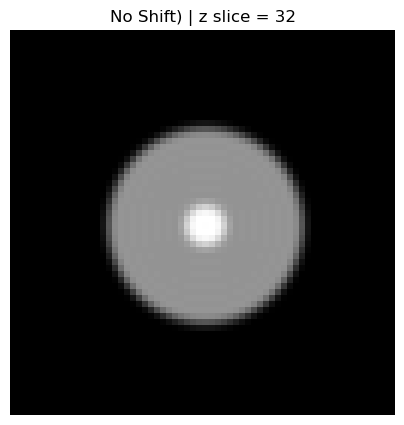


=== Case 2: Inner Cylinder Shifted ===


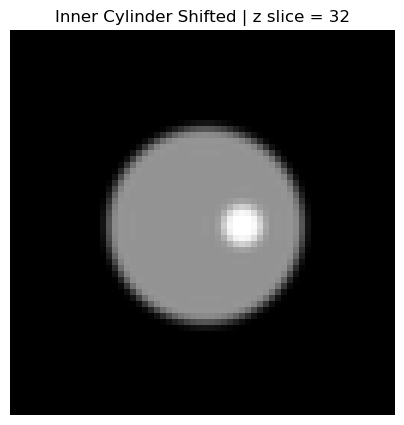


=== Case 3: Undo Shift ===


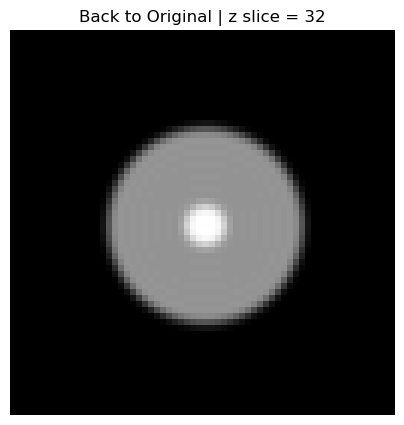


Max difference between original and un-shifted: 1.1718571004216928e-13
Mean difference: 4.650640325442011e-15


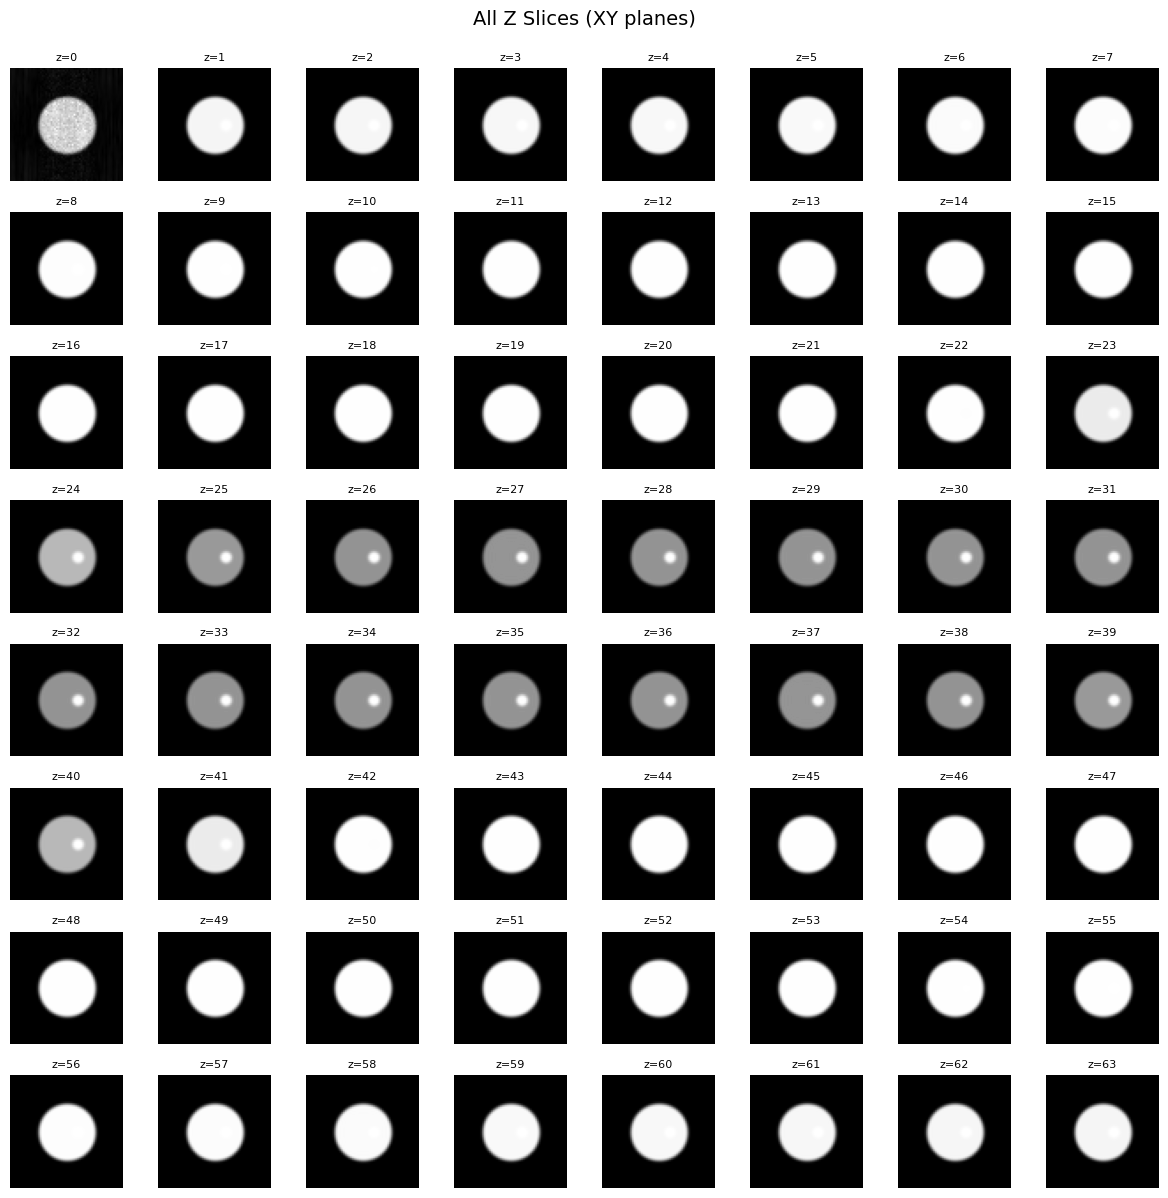

In [52]:
# Parameters
a_outer = 100.0  # Outer cylinder radius
a_inner = 20.0   # Inner cylinder radius 
h_outer = 250.0        # Height
h_inner = 100.0
size = 64       # K-space size
kmax = 0.5
shift_pixels_coord = (0.0, 6.0)  # Shift for inner cylinder only 
inner_intensity = 0.5  
outer_intensity = 0.7


ksp_outer, kmax = generate_ksp_cylinder(a=a_outer, h=h_outer, size=size, kmax=kmax)
ksp_inner, _ = generate_ksp_cylinder(a=a_inner, h=h_inner, size=size, kmax=kmax)

ksp_outer = outer_intensity*ksp_outer
ksp_inner = inner_intensity*ksp_inner

## Case 1: No shift - both cylinders in center
print("\n=== Case 1: No Shift ===")
ksp_combined_no_shift = ksp_outer + ksp_inner  
img_no_shift = ksp_to_image(ksp_combined_no_shift)
plot_xy_img_magnitude(img_no_shift, title='No Shift)')

##Case 2: Shift ONLY the inner cylinder
print("\n=== Case 2: Inner Cylinder Shifted ===")
ksp_inner_shifted = shift_pixels(ksp_inner, kmax, shift_pixels_coord)
ksp_combined_shifted = ksp_outer + ksp_inner_shifted  
img_shifted = ksp_to_image(ksp_combined_shifted)
plot_xy_img_magnitude(img_shifted, title='Inner Cylinder Shifted')
# plot_axes_img_magnitude(img_shifted, z_slice=50)

## Case 3: Undo the shift to get back to original
print("\n=== Case 3: Undo Shift ===")
shift_back = (-shift_pixels_coord[0], -shift_pixels_coord[1])
ksp_inner_unshifted = shift_pixels(ksp_inner_shifted, kmax, shift_back)
ksp_combined_unshifted = ksp_outer + ksp_inner_unshifted
img_unshifted = ksp_to_image(ksp_combined_unshifted)
plot_xy_img_magnitude(img_unshifted, title='Back to Original')

# Verify they are same
difference = np.abs(img_no_shift - img_unshifted)
print(f"\nMax difference between original and un-shifted: {np.max(difference)}")
print(f"Mean difference: {np.mean(difference)}")

plot_all_z_slices(img_shifted)